In [33]:
from airsenal.framework.bpl_interface import *
from airsenal.framework.utils import *
from airsenal.framework.mappings import alternative_team_names

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
model_team = get_fitted_team_model(get_current_season(), session)

In [3]:
# extract indices of current premier league teams
# val-1 because 1-indexed in model but 0-indexed in python
current_idx = {key: val-1 for key, val in model_team.team_indices.items()
               if key in CURRENT_TEAMS}

top6 = ['MCI', 'LIV', 'TOT', 'CHE', 'MUN', 'ARS']

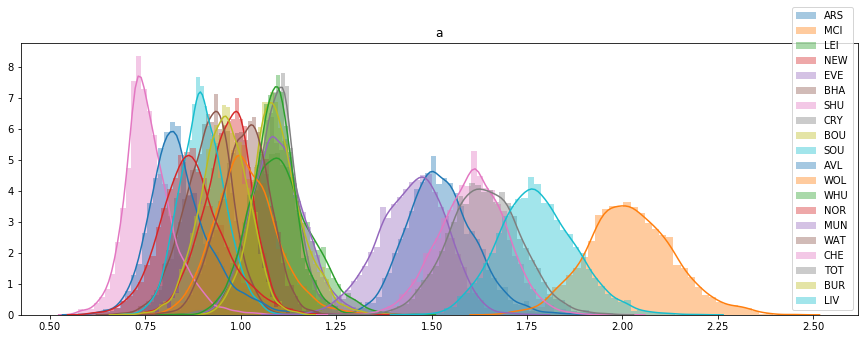

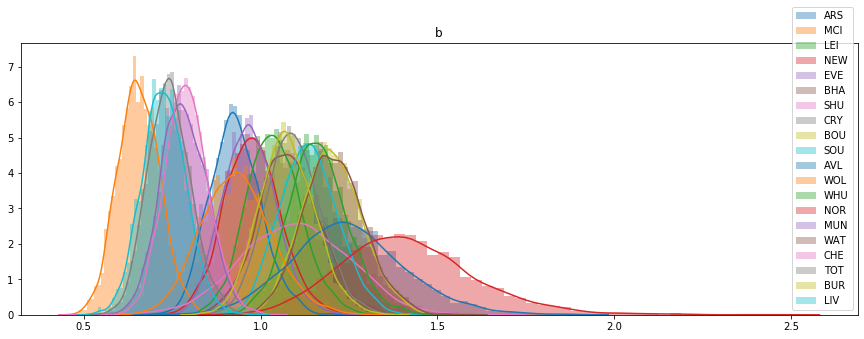

In [4]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.distplot(model_team.a[:, idx], label=team)
plt.title('a')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in current_idx.items():
    sns.distplot(model_team.b[:, idx], label=team)
plt.title('b')
plt.legend()

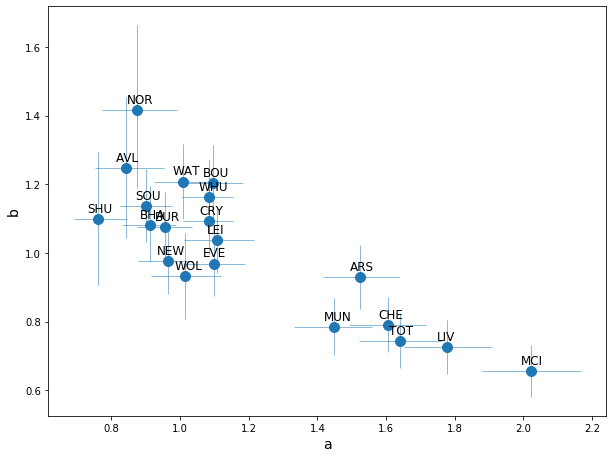

In [5]:
def plot_alpha_beta(model_team):
    a_mean = model_team.a.mean(axis=0)
    b_mean = model_team.b.mean(axis=0)

    a_conf95 = np.abs(np.quantile(model_team.a,[0.025, 0.975], axis=0) - a_mean)
    b_conf95 = np.abs(np.quantile(model_team.b, [0.025, 0.975], axis=0) - b_mean)
    a_conf80 = np.abs(np.quantile(model_team.a,[0.1, 0.9], axis=0) - a_mean)
    b_conf80 = np.abs(np.quantile(model_team.b, [0.1, 0.9], axis=0) - b_mean)

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(aspect='equal')
    plt.errorbar(a_mean[list(current_idx.values())],
                 b_mean[list(current_idx.values())],
                 xerr=a_conf80[:, list(current_idx.values())],
                 yerr=b_conf80[:, list(current_idx.values())],
                 marker='o', markersize=10,
                 linestyle='', linewidth=0.5)
    plt.xlabel('a', fontsize=14)
    plt.ylabel('b', fontsize=14)

    for team, idx in current_idx.items():
        ax.annotate(team,
                    (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                    fontsize=12)
        
plot_alpha_beta(model_team)

Text(0.5, 1.0, 'beta_b')

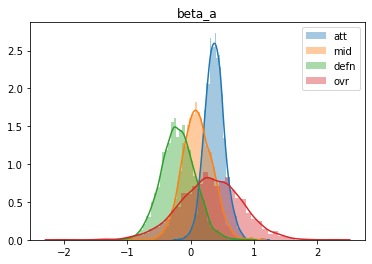

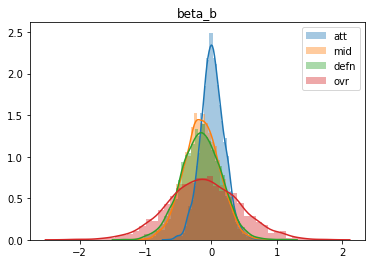

In [6]:
# team features (excluding first column which is team name)
feats = model_team.X.columns[1:]

for idx in range(model_team.beta_a.shape[1]):
    sns.distplot(model_team.beta_a[:,idx], 
                 label=feats[idx])

plt.legend()
plt.title('beta_a')

plt.figure()
for idx in range(model_team.beta_b.shape[1]):
    sns.distplot(model_team.beta_b[:,idx],
                 label=feats[idx])
plt.legend()
plt.title('beta_b')

(-0.8635099050080833, 0.6505176642983739)

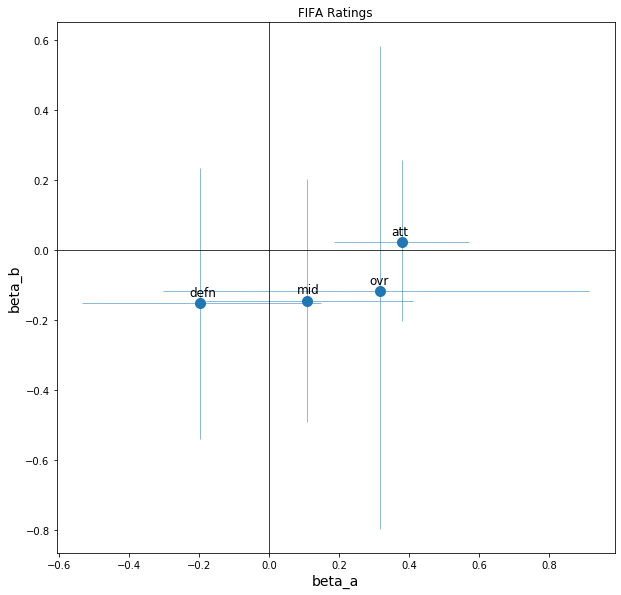

In [7]:
beta_a_mean = model_team.beta_a.mean(axis=0)
beta_b_mean = model_team.beta_b.mean(axis=0)

beta_a_conf95 = np.abs(np.quantile(model_team.beta_a,[0.025, 0.975], axis=0) - beta_a_mean)
beta_b_conf95 = np.abs(np.quantile(model_team.beta_b, [0.025, 0.975], axis=0) - beta_b_mean)
beta_a_conf80 = np.abs(np.quantile(model_team.beta_a,[0.1, 0.9], axis=0) - beta_a_mean)
beta_b_conf80 = np.abs(np.quantile(model_team.beta_b, [0.1, 0.9], axis=0) - beta_b_mean)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(aspect='equal')
plt.errorbar(beta_a_mean,
             beta_b_mean,
             xerr=beta_a_conf80,
             yerr=beta_b_conf80,
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('beta_a', fontsize=14)
plt.ylabel('beta_b', fontsize=14)
plt.title('FIFA Ratings')

for idx, feat in enumerate(feats):
    ax.annotate(feat,
                (beta_a_mean[idx]-0.03, beta_b_mean[idx]+0.02), 
                fontsize=12)
    
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.plot([0, 0], ylim, color='k', linewidth=0.75)
plt.plot(xlim, [0, 0], color='k', linewidth=0.75)
plt.xlim(xlim)
plt.ylim(ylim)

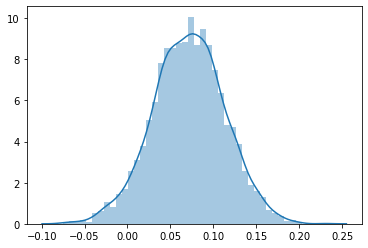

In [8]:
sns.distplot(model_team.beta_b_0)

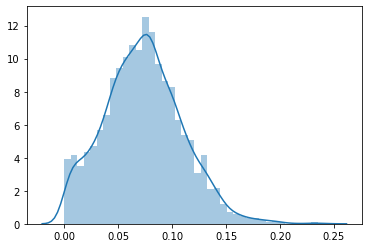

In [9]:
sns.distplot(model_team.sigma_a)

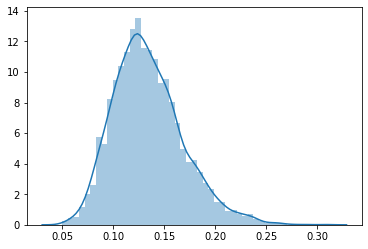

In [10]:
sns.distplot(model_team.sigma_b)

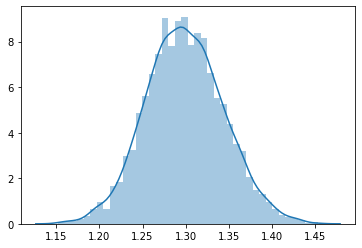

In [11]:
sns.distplot(model_team.gamma)

In [12]:
model_team.log_score()

-2.8519799565122805

In [13]:
team_h = "MCI"
team_a = "MUN"

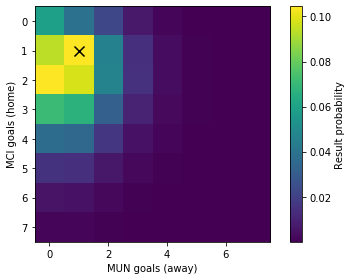

In [14]:
model_team.plot_score_probabilities(team_h, team_a);

In [15]:
model_team.concede_n_probability(2, team_h, team_a)

0.17378455428488107

In [16]:
model_team.score_n_probability(2, team_h, team_a)

0.26808286039748275

In [17]:
model_team.overall_probabilities(team_h, team_a)

(0.6191826417983328, 0.1592055804884443, 0.22161177614589617)

In [18]:
model_team.score_probability(team_h, team_a, 2, 2)

0.0465904626571891

(-1, 8)

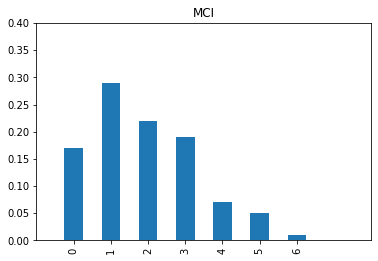

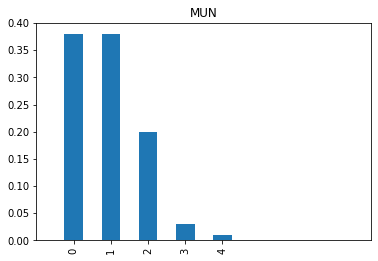

In [19]:
sim = model_team.simulate_match(team_h, team_a)
sim[team_h].value_counts(normalize=True).sort_index().plot.bar()
plt.title(team_h)
plt.ylim([0, 0.4])
plt.xlim([-1, 8])

plt.figure()
sim[team_a].value_counts(normalize=True).sort_index().plot.bar()
plt.title(team_a)
plt.ylim([0, 0.4])
plt.xlim([-1, 8])

MCI exp goals 2.0544216974805325
MUN exp goals 0.9506945252607913


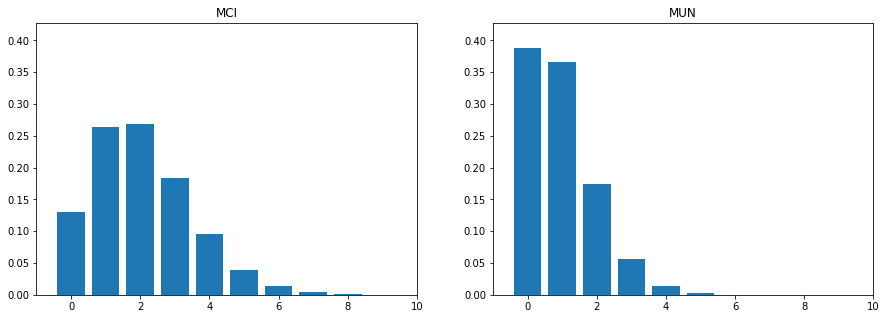

In [20]:
max_goals = 10

prob_score_h = [model_team.score_n_probability(n, team_h, team_a) for n in range(max_goals)]
print(team_h, "exp goals", sum([n*prob_score_h[n] for n in range(max_goals)])/sum(prob_score_h))

prob_score_a = [model_team.score_n_probability(n, team_a, team_h, home=False) for n in range(max_goals)]
print(team_a, "exp goals", sum([n*prob_score_a[n] for n in range(max_goals)])/sum(prob_score_a))

max_prob = 1.1*max(prob_score_h + prob_score_a)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(range(max_goals), prob_score_h)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_h)

plt.subplot(1,2,2)
plt.bar(range(max_goals), prob_score_a)
plt.ylim([0, max_prob])
plt.xlim([-1, max_goals])
plt.title(team_a);

In [21]:
df = model_team.simulate_match(team_h, team_a)
print(df.quantile(0.25))
print(df.median())
print(df.quantile(0.75))

MCI    1.0
MUN    0.0
Name: 0.25, dtype: float64
MCI    2.0
MUN    1.0
dtype: float64
MCI    3.0
MUN    2.0
Name: 0.75, dtype: float64


In [22]:
model_team.stan_data

{'nteam': 29,
 'nmatch': 1250,
 'home_team': array([23, 29, 27, ..., 25, 14,  6]),
 'away_team': array([ 5, 18,  6, ..., 26,  4, 27]),
 'home_goals': array([0, 2, 2, ..., 1, 0, 1]),
 'away_goals': array([4, 0, 2, ..., 2, 2, 1]),
 'X': array([[ 0.53734273,  0.7015235 ,  0.5307168 ,  0.65753551],
        [ 0.95013582,  1.2340937 ,  0.76569065,  0.99804496],
        [-0.39144172, -0.36361689, -0.4091786 , -0.36399287],
        [ 0.12454964, -0.04407478,  0.41322987,  0.20352289],
        [-0.08184691,  0.06243926,  0.0607691 ,  0.09001974],
        [ 0.02135137,  0.38198138,  0.41322987,  0.31702605],
        [-0.70103654, -0.68315901, -0.8791263 , -0.81800548],
        [-0.70103654, -0.47013093, -0.4091786 , -0.47749602],
        [-0.08184691,  0.06243926,  0.0607691 , -0.02348341],
        [-0.49464   , -0.47013093, -0.4091786 , -0.47749602],
        [-0.49464   , -0.36361689, -0.05671783, -0.25048972],
        [-0.39144172, -0.68315901, -0.52666553, -0.59099917],
        [-0.49464   , 

## Without FIFA ratings

(0.5, 1.7)

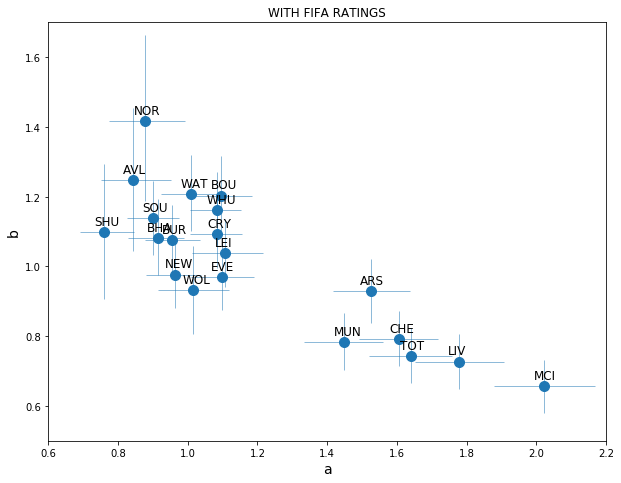

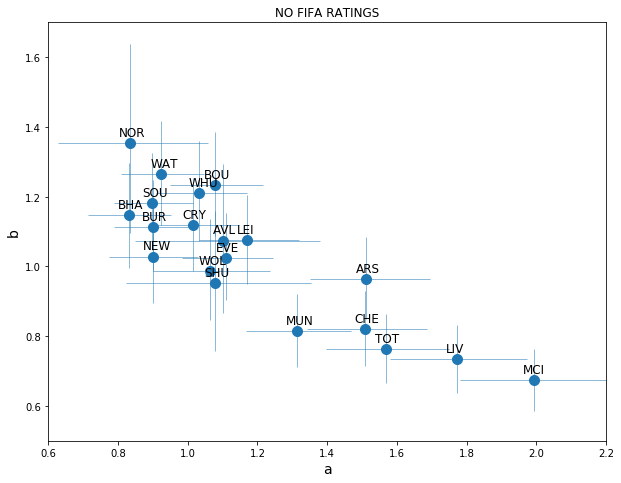

In [27]:
df_team = get_result_df(session)
model_nofifa = bpl.BPLModel(df_team, X=None)
model_nofifa.fit()

In [ ]:
plot_alpha_beta(model_team)
plt.title("WITH FIFA RATINGS")
plt.xlim((0.6, 2.2))
plt.ylim((0.5, 1.7))

plot_alpha_beta(model_nofifa)
plt.title("NO FIFA RATINGS")
plt.xlim((0.6, 2.2))
plt.ylim((0.5, 1.7))

In [26]:
print("WITH FIFA RATINGS:", model_team.log_score())
print("NO FIFA RATINGS:", model_nofifa.log_score())

WITH FIFA RATINGS: -2.8519799565122805
NO FIFA RATINGS: -2.846215710201006


## With latest FIFA ratings

In [51]:
df_team = get_result_df(session)

df_X = pd.read_csv("../airsenal/data/fifa_team_ratings_20191104.csv")
teams = []
for team in df_X["team_name"]:
    team_is_known = False
    for k, v in alternative_team_names.items():
        if team in v:
            team = k
            team_is_known = True
        elif team == k:
            team_is_known = True
    if not team_is_known:
        #print("Unknown team {}.".format(team))
        team = np.nan
    teams.append(team)
    
df_X["team"] = teams
df_X.dropna(inplace=True)
df_X.drop("team_name", axis=1, inplace=True)

model_newfifa = create_and_fit_team_model(df_team, df_X)

(0.5, 1.7)

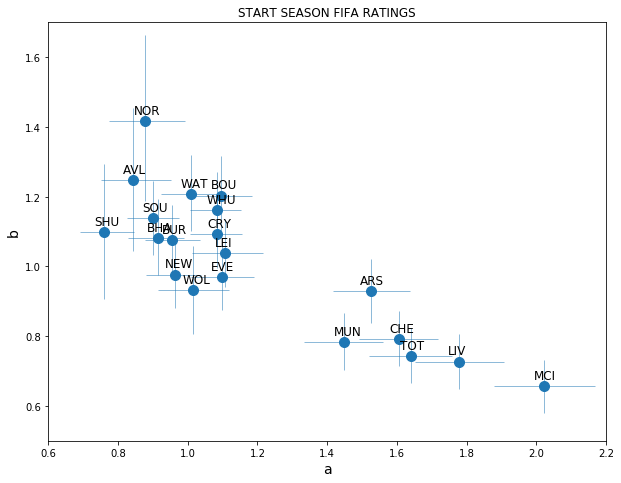

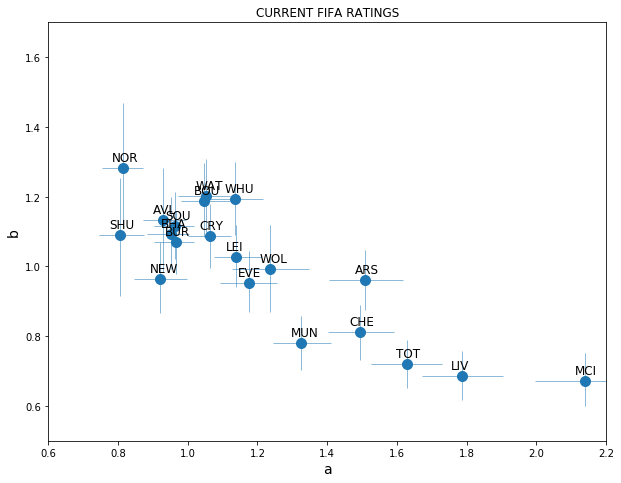

In [52]:
plot_alpha_beta(model_team)
plt.title("START SEASON FIFA RATINGS")
plt.xlim((0.6, 2.2))
plt.ylim((0.5, 1.7))

plot_alpha_beta(model_newfifa)
plt.title("CURRENT FIFA RATINGS")
plt.xlim((0.6, 2.2))
plt.ylim((0.5, 1.7))